In [1]:
!pip install imutils
!pip install image-classifiers==1.0.0b1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-py3-none-any.whl size=19968 sha256=734536d70fada71ba1c1538f8c7e8b2b03e03a3020898c8d328ba501e9cd92c5
  Stored in directory: /root/.cache/pip/wheels/59/ee/99/bdd974449ed4653c3c2e37d600817c9da816057dfa43c67878
Successfully built image-classifiers


In [2]:
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
import keras.applications
from datetime import datetime
%load_ext tensorboard

In [3]:
import os
import copy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img, img_to_array
#from keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
!pip install --upgrade -q kaggle

!mkdir /root/.kaggle
import json
token = {
    "username": "zahidhussain909",
    "key": "39a06efd89d0f2a699143b8d3d62b216"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)
!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d zahidhussain909/denoised-oct-balanced

import zipfile
zipref=zipfile.ZipFile("/content/denoised-oct-balanced.zip",'r')
zipref.extractall()
zipref.close()

100% 1.04G/1.05G [00:21<00:00, 38.3MB/s]
100% 1.05G/1.05G [00:21<00:00, 53.2MB/s]


In [5]:
SEED = 42
DIR_PATH = "/content/dataset"
W = 180 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 180 # The default size for ResNet is 224 but resize to .5 to save memory size
LABEL_TO_CLASS = {
    "cnv": 0,
    "dme":    1,
    "drusen":   2,
    "normal":  3,
}

N_EPOCHS = 5
BATCH_SIZE = 32

In [6]:
samples = 500
normal_dataset_path = '/content/DENOISED OCT/train/NORMAL'
cnv_dataset_path = '/content/DENOISED OCT/train/CNV'
dme_dataset_path = '/content/DENOISED OCT/train/DME'
drusen_dataset_path = '/content/DENOISED OCT/train/DRUSEN'

In [7]:
dataset_path = '/content/dataset'
log_path = '/content/logs'

!mkdir dataset
!mkdir logs

dataset_path = '/content/dataset'
log_path = '/content/logs'



In [8]:
!mkdir dataset/cnv
!mkdir dataset/normal

In [9]:
!mkdir dataset/dme
!mkdir dataset/drusen

In [10]:
basePath = normal_dataset_path
imagePaths = list(paths.list_images(basePath))
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]
for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])
    shutil.copy2(imagePath, outputPath)

In [11]:
basePath = cnv_dataset_path
imagePaths = list(paths.list_images(basePath))
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]
for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/cnv", filename])
    shutil.copy2(imagePath, outputPath)

In [12]:
basePath = dme_dataset_path
imagePaths = list(paths.list_images(basePath))
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]
for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/dme", filename])
    shutil.copy2(imagePath, outputPath)


In [13]:
basePath = drusen_dataset_path
imagePaths = list(paths.list_images(basePath))
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]
for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/drusen", filename])
    shutil.copy2(imagePath, outputPath)

In [14]:
CLASS_TO_LABEL = {v: k for k, v in LABEL_TO_CLASS.items()}
N_CLASSES = len(LABEL_TO_CLASS)

In [15]:
def get_images(
        dir_path, 
        label_to_class, 
        w, 
        h, 
        seed,
    ):
    """Read images / labels from directory.
    
    Args:
        dir_path (str): Dir path saved data.
        label_to_class (dict[str, int]): Dict of label to class.
        w (int): Width size of image.
        h (int): Height size of image.
        seed (int): Random seed.
    
    Returns:
        tuple[np.ndarray, np.ndarray]: images, classes.
    """
    images = []
    classes = []
    
    for label_name in os.listdir(dir_path):
        cls = label_to_class[label_name]
        for img_name in os.listdir("/".join([dir_path, label_name])):
            img = load_img("/".join([dir_path, label_name, img_name]), target_size=(w, h))
            img = img_to_array(img)
            images.append(img)
            classes.append(cls)
            
    images = np.array(images, dtype=np.float32)
    classes = np.array(classes, dtype=np.float32)
    images, classes = shuffle(images, classes, random_state=seed)
    
    return images, classes


def split_dataset(
        images, 
        classes, 
        train_size=0.8, 
        test_size=0.2, 
        shuffle=False,
    ):
    """Split dataset.
    
    Args:
        images (np.ndarray): images.
        classes (np.ndarray): classes.
        train_size (float): Train data rate of split data.
        test_size (float): Test data rate of split data.
        shuffle (bool): Shuffle or not.
    
    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: X of train, y of train, X of test, y of test.
    """
    indices_train, indices_test = train_test_split(
        list(range(images.shape[0])), 
        train_size=train_size,
        test_size=test_size,
        shuffle=shuffle,
    )

    x_train = images[indices_train]
    y_train = classes[indices_train]
    x_test = images[indices_test]
    y_test = classes[indices_test]
    
    return x_train, y_train, x_test, y_test


def build_model(w, h, n_classes):
    """Build model function.
    
    Args:
        w (int): Width size of image.
        h (int): Height size of image.
        n_classes (int): The number of class.
        
    Returns:
        keras.engine.training.Model: Model.
    """ 
    # Resnet
    input_tensor = Input(shape=(w, h, 3)) # To change input shape
    resnet50 = ResNet50(
        include_top=False,                # To change output shape
        weights="imagenet",               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
    
    # fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())               # Add GAP for cam
    top_model.add(Dense(n_classes, activation="softmax")) # Change output shape for this task
    
    # model
    model = Model(input=resnet50.input, output=top_model(resnet50.output))
    
    # frozen weights
    for layer in model.layers[:-10]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable
        
    # compile
    model.compile(
        optimizer="adam", 
        loss="categorical_crossentropy", 
        metrics=["accuracy"],
    )
    
    return model


def plot_confusion_matrix(model, x_test, label_to_class):
    """Plot confusion matrix.
    
    Args:
        model (keras.engine.training.Model): Model.
        x_test (np.ndarray): X of test.
        label_to_class (dict[str, int]): Dict of label to class.
    """
    x = preprocess_input(copy.deepcopy(x_test))
    y_preds = model.predict(x)
    y_preds = np.argmax(y_preds, axis=1)
    y_trues = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_trues, y_preds)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={"shrink": .3}, linewidths=.1, ax=ax)
    ax.set(
        xticklabels=list(label_to_class.keys()),
        yticklabels=list(label_to_class.keys()),
        title="confusion matrix",
        ylabel="True label",
        xlabel="Predicted label",
    )
    params = dict(rotation=45, ha="center", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), **params)
    plt.setp(ax.get_xticklabels(), **params)
    plt.show()
    
    
def superimpose(img, cam):
    """Superimpose original image and cam heatmap.
    
    Args:
        img (np.ndarray): Image.
        cam (np.ndarray): Cam image.
        
    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: Image, heatmap, superimposed image.
    """
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8) # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img


def plot_org_img_and_cam_heatmap(
        model, 
        cam_func, 
        superimpose, 
        img, 
        cls_true, 
        class_to_label, 
        cam_name,
    ):
    """Plot original image, heatmap from cam and superimpose image.
    
    Args:
        model (keras.engine.training.Model): Model.
        cam_func (function): Cam function.
        superimpose (function): Superimpose function.
        img (np.ndarray): Image.
        cls_true (float): Class of given img.
        class_to_label (dict[int, str]): Dict of class to label.
        cam_name (str): Used cam name.
    """
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title("original image")
    axs[0].axis("off")

    axs[1].imshow(heatmap)
    axs[1].set_title("heatmap")
    axs[1].axis("off")

    axs[2].imshow(superimposed_img)
    axs[2].set_title("superimposed image")
    axs[2].axis("off")

    title = "CAM name: " + cam_name + " / True label: " + class_to_label[cls_true] + " / Predicted label : " + class_to_label[cls_pred]
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

def grad_cam(model, x, layer_name):
    """Grad-CAM function.
    
    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name
        
    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.GradientTape(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0
    
    return cls, cam


def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function.
    
    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name.
        
    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.GradientTape(y_c, conv_output)[0]

    # first / second / third derivative
    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    # Get outputs, grads and higher order derivatives
    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    
    # Calculate weight alpha
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0)
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2) # multiply
    cam = np.maximum(cam, 0)                                          # Passing through ReLU
    cam /= np.max(cam)                                                # scale 0 to 1.0  

    return cls, cam


def softmax(x):
    """Softmax function.
    
    Args:
        x (np.ndarray): Input.
        
    Returns:
        np.ndarray: Softmax(x)
    """
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


def score_cam(
        model, 
        x, 
        layer_name, 
        max_N=-1,
    ):
    """Score-CAM function.
    
    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name.
        max_N (int): max N.
        
    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    cls = np.argmax(model.predict(x))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(x)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0, :, :, k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:, :, :, max_N_indices]

    input_shape = model.layers[0].output_shape[1:]  # get input shape
    
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
        
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(x)
        for k in range(3):
            masked_input[0, :, :, k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:, cls]
    
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0, :, :, :], weights) # multiply
    cam = np.maximum(0, cam)                         # Passing through ReLU
    cam /= np.max(cam)                               # scale 0 to 1.0
    
    return cls, cam


def compare_each_cam(
        images, 
        classes, 
        class_to_label, 
        model, 
        grad_cam, 
        grad_cam_plus_plus, 
        score_cam, 
        superimpose, 
        layer_name, 
        target_cls,
    ):
    """Compare Grad-CAM / Grad-CAM++ / Score-CAM on target class images.
    
    Args:
        images (np.ndarray): images.
        classes (np.ndarray): classes.
        class_to_label (dict[int, str]): Dict of class to label.
        model (keras.engine.training.Model): Model.
        grad_cam (function): Grad-CAM function.
        grad_cam_plus_plus (function): Grad-CAM++ function.
        score_cam (function): Score-CAM function.
        superimpose (function): Superimpose function.
        layer_name (str): Get layer name.
        target_cls (int): Target class.
    """
    indices = np.where(classes == target_cls)[0]
    label = class_to_label[target_cls]

    n_cols = 10 # # of sample plot

    fig, axs = plt.subplots(ncols=n_cols, nrows=4, figsize=(25, 9))

    for i in range(n_cols):
        
        img = images[indices[i]]
        
        # for cam
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0, i].imshow(np.uint8(img))
        axs[0, i].set_title(label)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        if i == 0:
            axs[0, i].set_ylabel("Original", rotation=0, ha="right")

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1, i].imshow(img_grad_cam)
        axs[1, i].set_title("pred: " + class_to_label[cls_pred])
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        if i == 0:
            axs[1, i].set_ylabel("Grad-CAM", rotation=0, ha="right")

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2, i].imshow(img_grad_cam_plus_plus)
        axs[2, i].set_title("pred: " + class_to_label[cls_pred])
        axs[2, i].set_xticks([])
        axs[2, i].set_yticks([])
        if i == 0:
            axs[2, i].set_ylabel("Grad-CAM++", rotation=0, ha="right")

        # Score-CAM
        cls_pred, cam = score_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_score_cam = superimpose(img, cam)
        axs[3, i].imshow(img_score_cam)
        axs[3, i].set_title("pred: " + class_to_label[cls_pred])
        axs[3, i].set_xticks([])
        axs[3, i].set_yticks([])
        if i == 0:
            axs[3, i].set_ylabel("Score-CAM", rotation=0, ha="right")

    plt.show()

<h2>(4) Prepare data</h2>

In [16]:
images, classes = get_images(
    dir_path=DIR_PATH, 
    label_to_class=LABEL_TO_CLASS,
    w=180,
    h=180,
    seed=SEED,
)

images.shape, classes.shape

((2000, 180, 180, 3), (2000,))

In [17]:
# Check the number of images for each labels

n_total_images = images.shape[0]
for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0] # get target class indices on images / classes
    n_target_cls = indices.shape[0]
    label = CLASS_TO_LABEL[target_cls]
    print(label, ":", n_target_cls, round(n_target_cls / n_total_images, 2))

cnv : 500 0.25
dme : 500 0.25
drusen : 500 0.25
normal : 500 0.25


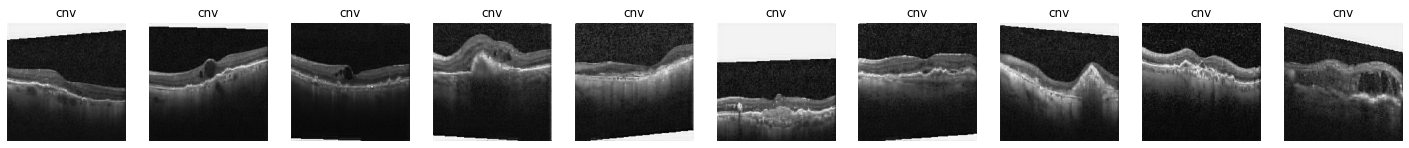

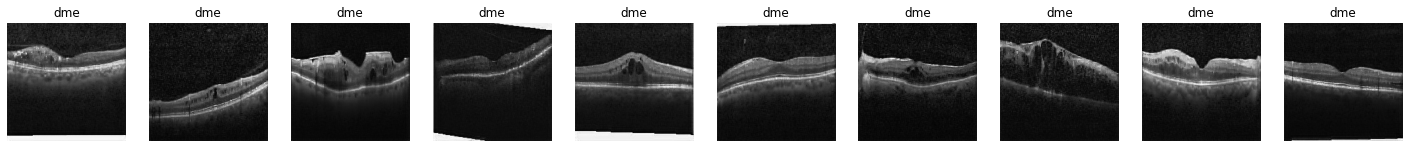

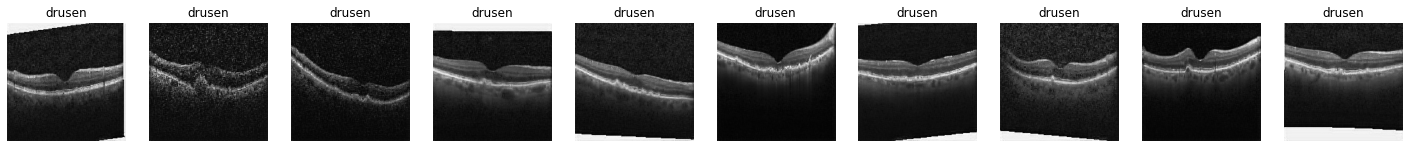

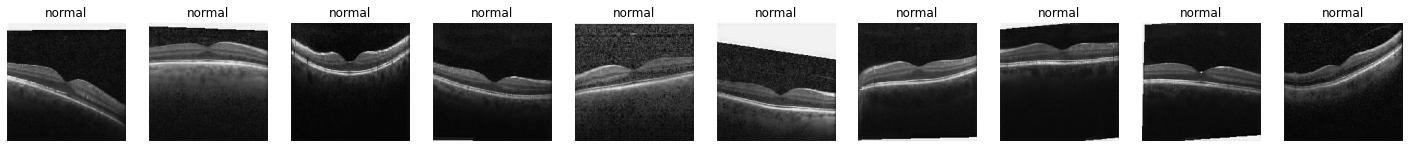

In [18]:
# Visualize some images / labels

for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0] # get target class indices on images / classes
    label = CLASS_TO_LABEL[target_cls]

    n_cols = 10 # The number of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):
        axs[i].imshow(np.uint8(images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

<h2> (5) Preprocess for train</h2>

In [19]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x_train, y_train, x_test, y_test = split_dataset(images, classes)

# to one-hot

y_train = keras.utils.to_categorical(y_train, N_CLASSES)
y_test = keras.utils.to_categorical(y_test, N_CLASSES)

# To image data generator
# Use image data augmentation for train data

datagen_train = ImageDataGenerator(
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [21]:
#model = build_model(w=W, h=H, n_classes=N_CLASSES)
model = tf.keras.models.load_model('/content/classify_model4.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 100)     2800      
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 100)    400       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 70)        63070     
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 70)       280       
 hNormalization)                                                 
                                                        

<h2>(7) Finetuning the model</h2>

In [21]:
history = model.fit_generator(
    datagen_train.flow(
        x_train, 
        y_train, 
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test, 
        y_test, 
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
50/50 [==============================] - 20s 150ms/step - loss: 0.2125 - auc: 0.9912 - precision: 0.9304 - recall: 0.9187 - precision_at_recall: 0.9977 - true_negatives: 4690.0000 - false_positives: 110.0000 - specificity_at_sensitivity: 0.9996 - accuracy: 0.9269 - val_loss: 10193.1855 - val_auc: 0.4833 - val_precision: 0.2250 - val_recall: 0.2250 - val_precision_at_recall: 0.0000e+00 - val_true_negatives: 890.0000 - val_false_positives: 310.0000 - val_specificity_at_sensitivity: 0.0000e+00 - val_accuracy: 0.2250
Epoch 2/5
50/50 [==============================] - 4s 89ms/step - loss: 0.1380 - auc: 0.9958 - precision: 0.9528 - recall: 0.9469 - precision_at_recall: 0.9988 - true_negatives: 4725.0000 - false_positives: 75.0000 - specificity_at_sensitivity: 0.9998 - accuracy: 0.9494 - val_loss: 10774.6367 - val_auc: 0.4833 - val_precision: 0.2250 - val_recall: 0.2250 - val_precision_at_recall: 0.0000e+00 - val_true_negatives: 890.0000 - val_false_positives: 310.0000 - val_specifi

13/13 [==============================] - 9s 38ms/step


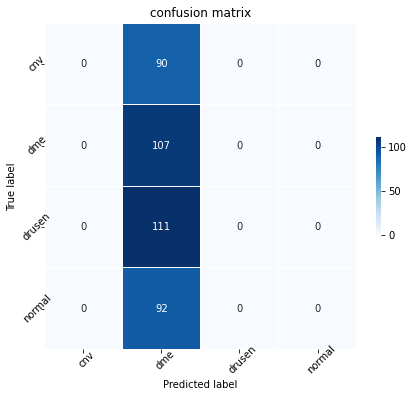

In [22]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

<h2>(8) Implement Grad-CAM, Grad-CAM++ and Score CAM</h2>

In [14]:
import tensorflow as tf


In [26]:
# plot_org_img_and_cam_heatmap(
#     model=model, 
#     cam_func=grad_cam,
#     superimpose=superimpose,
#     img=images[0],
#     cls_true=classes[0], 
#     class_to_label=CLASS_TO_LABEL, 
#     cam_name="Grad-CAM",
# )
# plot_org_img_and_cam_heatmap(
#     model=model, 
#     cam_func=grad_cam_plus_plus,
#     superimpose=superimpose,
#     img=images[0], 
#     cls_true=classes[0], 
#     class_to_label=CLASS_TO_LABEL,
#     cam_name="Grad-CAM++",
# )
plot_org_img_and_cam_heatmap(
    model=model, 
    cam_func=score_cam,
    superimpose=superimpose,
    img=images[2], 
    cls_true=classes[1], 
    class_to_label=CLASS_TO_LABEL, 
    cam_name="Score-CAM",
)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 94ms/step


IndexError: ignored

<h2>(9) Compare with each cam</h2> 

1/1 [==============================] - 0s 20ms/step


TypeError: ignored

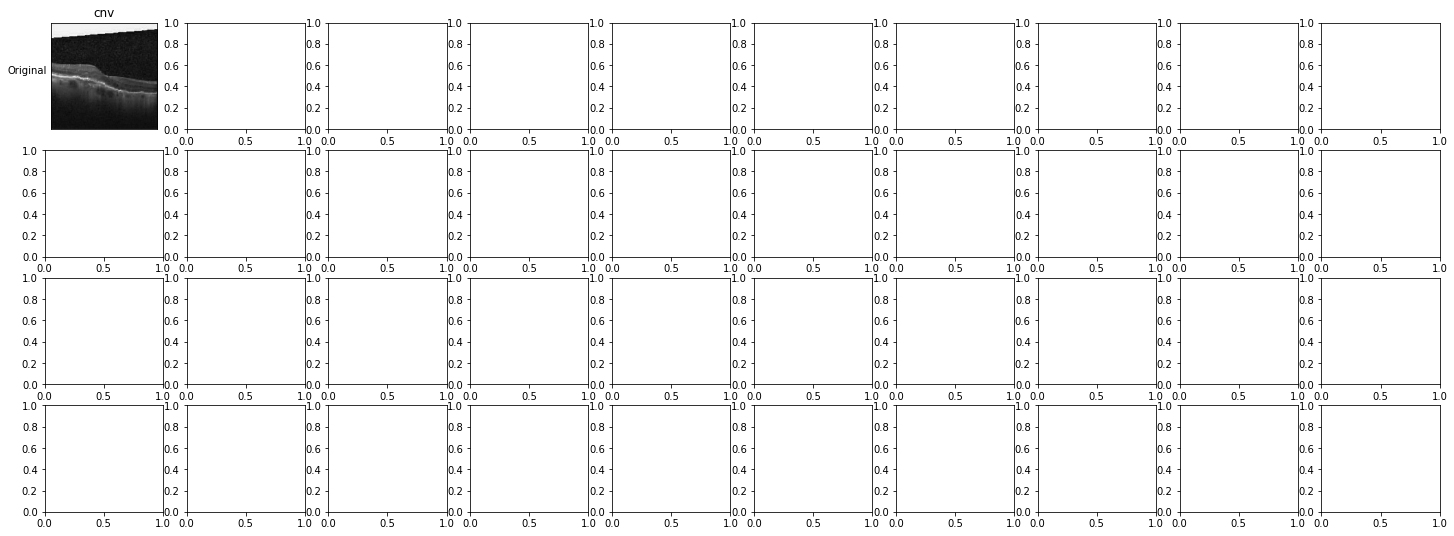

In [27]:
for k, v in LABEL_TO_CLASS.items():
    compare_each_cam(
        images=images, 
        classes=classes, 
        class_to_label=CLASS_TO_LABEL,
        model=model,
        grad_cam=grad_cam, 
        grad_cam_plus_plus=grad_cam_plus_plus, 
        score_cam=score_cam, 
        superimpose=superimpose, 
        layer_name=model.layers[-2].name, 
        target_cls=v,
    )

<h2>Insights</h2>
<p>
<b>- buildings</b><br>
モデルは建物を直接見て判断しているように見えます。<br>
また、Grad-CAM++とScore-CAMの方が、Grad-CAMよりも反応が大きいように見えます。<br>
<br>
<b>- forest</b><br>
モデルは木の幹の部分を見て判断しているように見えます。<br>
また、Grad-CAM++とScore-CAMの方が、Grad-CAMよりもより正しい位置に反応しているように見えます。<br>
<br>
<b>- glacier</b><br>
モデルは山の形を見て判断しているように見えます。<br>
各可視化手法であまり違いがないように見えます。<br>
<br>
<b>- mountain</b><br>
モデルは山の形を見て判断しているように見えます。<br>
各可視化手法であまり違いがないように見えます。<br>
この結果は glacier と似ています。<br>
上記でプロットして混合行列を見ても分かるように、このモデルでは glacier と mountain の分類がやや苦手のようです。実際、我々人間が見ても、どちらに分類すべきか分かりづらい画像がいくつか見受けられます。<br>
<br>
<b>- sea</b><br>
モデルは海の水平線を見て判断しているように見えます。<br>
また、Grad-CAM++とScore-CAMの方が、Grad-CAMよりも全体的に水平線に反応しているように見えます。<br>
<br>
<b>- street</b><br>
モデルは道の路面と両側に建つ建物を見て判断しているように見えます。<br>
また、Grad-CAM++とScore-CAMの方が、路面には、Grad-CAMよりも全体的に反応しているように見えます。<br>
<br>
<b>Overall</b><br>
Grad-CAM++とScore-CAMの方が、Grad-CAMよりもより画像の分類に関係がありそうな箇所を全体的に捉えているように見えました。<br>
Grad-CAM++とScore-CAMの間にはそこまで大きな差はなさそうに見えます。<br>
したがって、Grad-CAM++またはScore-CAMが個人的にはオススメかなと思いました。<br>
<br>
====================================<br>
<br>
<b>- buildings</b><br>
The model is looking at a building directly.<br>
It seems like Grad-CAM++ and Score-CAM are reacting more large than Grad-CAM.<br>
<br>
<b>- forest</b><br>
The model is looking at tree trunks.<br>
It seems like Grad-CAM++ and Score-CAM are reacting to to the correct position than Grad-CAM.<br>
<br>
<b>- glacier</b><br>
The model is looking at the shape of mountain.<br>
It seems like there are few difference for each methods.<br>
<br>
<b>- mountain</b><br>
The model is looking at the shape of mountain.<br>
It seems like there are few difference for each methods.<br>
The result is similart to glacier's one.<br>
As you can see from the confusion matrix, the model is not good at classify mountain and glacier. Actually, there are some images that are not sure which one to classify even if us (human).<br>
<br>
<b>- sea</b><br>
The model is looking at the surface of sea.<br>
Grad-CAM++ and Score-CAM are reacting overall of sea than Grad-CAM.<br>
<br>
<b>- street</b><br>
The model is looking at the surface of road and the building standing on both sides of the road.<br>
Grad-CAM++ and Score-CAM are reacting overall of road surface than Grad-CAM.<br>
<br>
<b>Overall</b><br>
It seems like Grad-CAM++ and Score-CAM could react overall of relevant area to classify than Grad-CAM.<br>
And There was few difference between Grad-CAM++ and Score-CAM.<br>
So I though using Grad-CAM++ or Score-CAM is my recommend.<br>
<br>
</p>

In [ ]:
!pip freeze > requirements.txt
!python --version > py_ver.txt
!cat /proc/driver/nvidia/version > nvidia_ver.txt

Python 3.6.6 :: Anaconda, Inc.
